This notebook is based on the following article:
https://arxiv.org/abs/2305.10990

This article examines random systems and their statistical calculations using Kramermoyal coefficients and moments.
In this notebook, according to the equations that we will write below, we will calculate a matrix equation, then calculate D and finally draw it.

In [7]:
import pandas as pd
import numpy as np
from scipy.linalg import solve
from scipy.stats import linregress
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.special import factorial

In [2]:
# Loading data. You can put your researched data here
df = pd.read_csv('df_bins_2.5.csv')
# df = pd.read_csv('QUOTAS_3only.csv')
df = df[(df != 0).all(axis=1) & df.notna().all(axis=1)]
redshifts = df['z'].values
luminosity = df['log_lbol'].values
masses = df['log_bh'].values
#data = luminosity
data = masses
print(len(redshifts))

12358


### Performing calculations related to equation 5

$$ y_l(t) = (x(t+\tau)-x(t))^l$$
$x$ is actually our data
The matrix of $y$ and equations for $l=2$: 
$$\begin{pmatrix}
<y_l> \\
<x*y_l> \\
<x^2*y_l> \\
\end{pmatrix} =
\begin{pmatrix}
1 & <x> & <x^2> \\
<x> & <x^2> & <x^3> \\
<x^2> & <x^3> & <x^4> \\
\end{pmatrix}
\begin{pmatrix}
\phi_0 \\
\phi_1\\
\phi_2 \\
\end{pmatrix} $$
Generally
$$\begin{pmatrix} 
<y_l> \\
<x*y_l> \\
<x^2*y_l> \\
....\\
<x^{l'}*y_{l}> \\
\end{pmatrix} =
\begin{pmatrix}
1 & <x> & <x^2> & ..... & <x^{l'}> \\
<x> & <x^2> & <x^3> & ..... & <x^{l'+1}> \\
<x^2> & <x^3> & <x^4> & ..... & <x^{l'+2}> \\
.......& .....& .....& .......& .......\\
<x^{l'}> & <x^{l'+1}> & <x^{l'+2}>& .......& <x^{2l'}>\\
\end{pmatrix} 
\begin{pmatrix}
\phi_0 \\
\phi_1\\
\phi_2 \\
......\\
\phi_{l'}
\end{pmatrix}
$$
#### In the cell below,

we consider a specific state to start the work and perform calculations for l=2. And we calculate the $\phi$.

Of course, in general, you should know that the determination of l depends on your data. In fact, the proper l is equal to the order of the data plus 2

In [3]:
def y(x, l):
    return (np.diff(x) ** l)

def solve_system(x, l):
    y_l = y(x, l)
    
    # Calculating means
    mean_y_l = np.mean(y_l)
    mean_x_y_l = np.mean(x[:-1] * y_l)   # Because the length of x and y are not equal. So we move X to the last one left
    mean_x2_y_l = np.mean((x[:-1] ** 2) * y_l)
    
    mean_x = np.mean(x)
    mean_x2 = np.mean(x ** 2)
    mean_x3 = np.mean(x ** 3)
    mean_x4 = np.mean(x ** 4)
    
    # Left hand side vector
    lhs = np.array([mean_y_l, mean_x_y_l, mean_x2_y_l])
    
    # Right hand side matrix
    rhs = np.array([    [1, mean_x, mean_x2],
                        [mean_x, mean_x2, mean_x3],
                        [mean_x2, mean_x3, mean_x4] ])
    
    # Solving the system of equations
    phi = solve(rhs, lhs)
    return phi

# Example: Solving for mass data
phi_values = solve_system(data, 2)

print("y : " , y(data, 2) )
print("Phi values:", phi_values)

y :  [0.02950175 1.89049377 0.38639949 ... 0.58662854 1.72532351 0.03381115]
Phi values: [ 77.76574299 -17.78774575   1.0193751 ]


### The cell below

Now we go to a more general state in the cell below. Making the matrix in the general mode for each value of l and calculating the phi

In [4]:
def y(x, l):
    return np.diff(x) ** l

def solve_system(x, l):
    y_l = y(x, l)
    n = len(x) - 1  
    x_truncated = x[:-1]  
    
    # Calculating means
    means_y_l = [np.mean(y_l * (x_truncated ** i)) for i in range(l + 1)]
    means_x = [np.mean(x ** i) for i in range(2 * l + 1)]

    # Left hand side vector
    lhs = np.array(means_y_l)
    
    # Right hand side matrix
    rhs = np.array([[means_x[i + j] for j in range(l + 1)] for i in range(l + 1)])
    
    # Solving the system of equations
    phi = solve(rhs, lhs)
    
    return phi

l_value = 2

phi_values = solve_system(data, l_value)

print("y : ", y(data, l_value))
print("Phi values:", phi_values)

y :  [0.02950175 1.89049377 0.38639949 ... 0.58662854 1.72532351 0.03381115]
Phi values: [ 77.76574299 -17.78774575   1.0193751 ]


### Equation 6
Now is the time to calculate equation 6. This equation is as follows
$$D^l(x,t) = lim_{\tau \to 0}  {1 \over {l!}} {1 \over {\tau}} {[\phi_0+\phi_1x+... + \phi_{l'}x^{l'}]}$$


/tmp/ipykernel_914422/1963592307.py:5: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  D = phi_x / (delta_t*np.math.factorial(l))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D_l :  [22.75387804 33.54546203 31.47754192 ... 29.65823196 31.14590446
 20.35064075]
len D_l :  12358


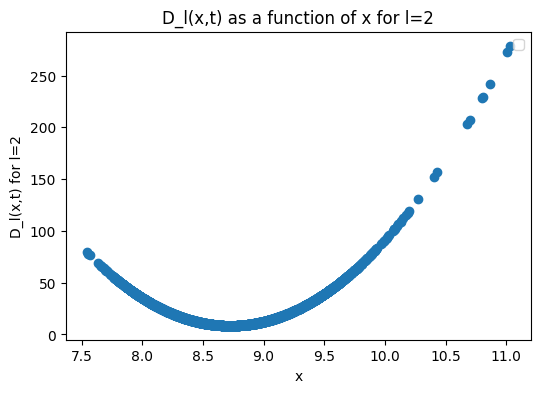

In [5]:
def D_l(x, phi, l):
    x_terms = np.array([x**i for i in range(l + 1)])
    phi_x = np.dot(phi, x_terms)
    delta_t = 0.01
    D = phi_x / (delta_t*np.math.factorial(l))
    return D

D_values = D_l(data, phi_values, l_value) 
print("D_l : " , D_values)
print("len D_l : " , len(D_values))

# Plotting D as a function of x
plt.figure(figsize=( 6, 4))
#plt.plot(data, D_values, 'o-', label='D(x)')
plt.scatter(data,D_values)

plt.ylabel(f'D_l(x,t) for l={l_value}')
plt.title(f'D_l(x,t) as a function of x for l={l_value}')
plt.xlabel('x')
#plt.ylabel('D_l(x,t)')
#plt.title('D_l(x,t) as a function of x')
plt.legend()
plt.show()

## Placement of different ls

By changing l, you can also draw different values of D.

But due to errors in the mismatch of lengths at the time of drawing, so I rewrite the functions and the parts where the changes have been made are completely clear.

D_l for l=1: [-52.85472408 -70.02272924  67.40791495 ... -11.85399838  64.70170461
 -66.58816806]
D_l for l=2: [22.75615172 33.54773449 31.47366176 ...  9.15001702 29.65460889
 31.14819475]
D_l for l=3: [ -6.45219585 -11.54569224  11.20689574 ...  -0.62444092  10.30930894
 -10.35036215]
D_l for l=4: [1.54025255 2.80147736 3.08903407 ... 0.65007204 2.76300547 2.47414966]
D_l for l=5: [-0.60298928 -0.8152087   0.55433304 ...  0.02775474  0.48035157
 -0.77289398]
D_l for l=6: [ 0.18060289  0.24730189  0.22508457 ... -0.02413913  0.21657272
  0.238205  ]


/tmp/ipykernel_914422/351473525.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=1.46686e-17): result may not be accurate.
  phi = solve(rhs, lhs)
/tmp/ipykernel_914422/351473525.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=1.26591e-21): result may not be accurate.
  phi = solve(rhs, lhs)
/tmp/ipykernel_914422/351473525.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=3.38249e-25): result may not be accurate.
  phi = solve(rhs, lhs)


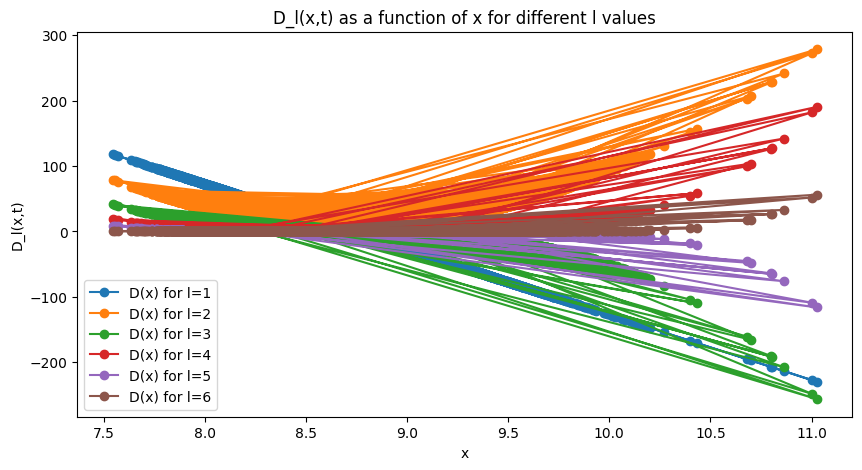

In [9]:
def solve_system(x, l):
    y_l = y(x, l)
    n = len(x) - 1  
    x_truncated = x[:-1]  
    
    # Calculating means
    means_y_l = [np.mean(y_l * (x_truncated ** i)) for i in range(l + 1)]
    means_x = [np.mean(x_truncated ** i) for i in range(2 * l + 1)]      ###### Changed to x_truncated
    # Left hand side vector
    lhs = np.array(means_y_l)
    # Right hand side matrix
    rhs = np.array([[means_x[i + j] for j in range(l + 1)] for i in range(l + 1)])
    # Solving the system of equations
    phi = solve(rhs, lhs)
    return phi

def D_l(x, phi, l):
    x_truncated = x[:-1]                                       # Adjusting length to match np.diff(x)
    x_terms = np.array([x_truncated**i for i in range(l + 1)])
    phi_x = np.dot(phi, x_terms)
    delta_t = 0.01
    D = phi_x / (delta_t * factorial(l))
    return D

l_values = [1, 2, 3, 4, 5, 6]  # Example l values

all_D_values = {}
for l_value in l_values:
    phi_values = solve_system(data, l_value)
    D_values = D_l(data, phi_values, l_value)
    all_D_values[l_value] = D_values
    print(f"D_l for l={l_value}:", D_values)

# Plotting D as a function of x for all l values on the same plot
plt.figure(figsize=(10, 5))
for l_value in l_values:
    plt.plot(data[:-1], all_D_values[l_value], 'o-', label=f'D(x) for l={l_value}')  # Changed to data[:-1]
plt.xlabel('x')
plt.ylabel('D_l(x,t)')
plt.title('D_l(x,t) as a function of x for different l values')
plt.legend()
plt.show()

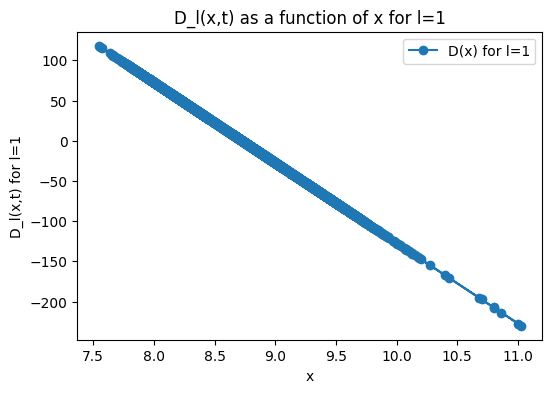

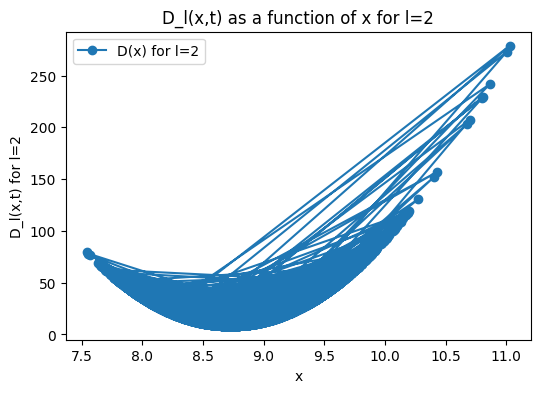

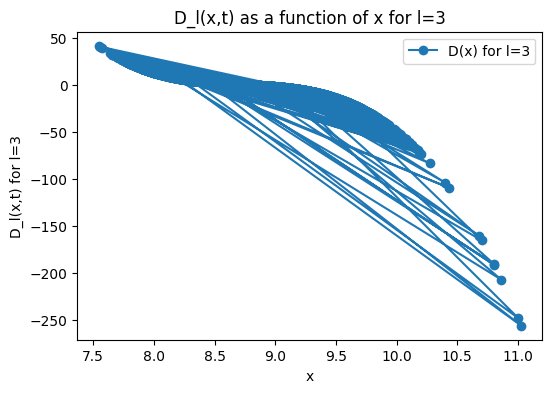

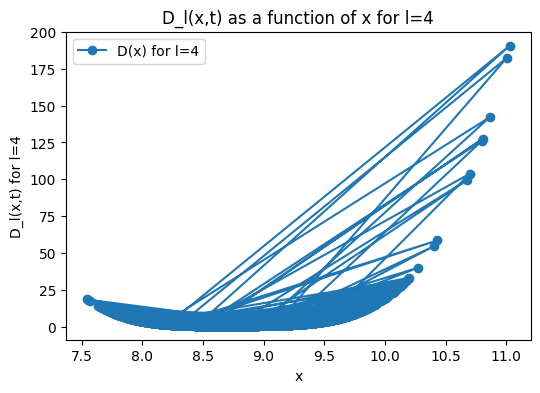

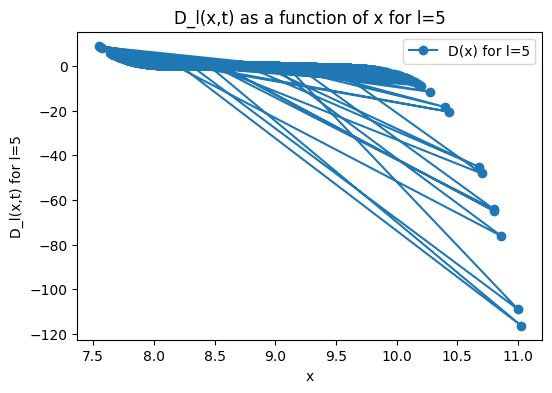

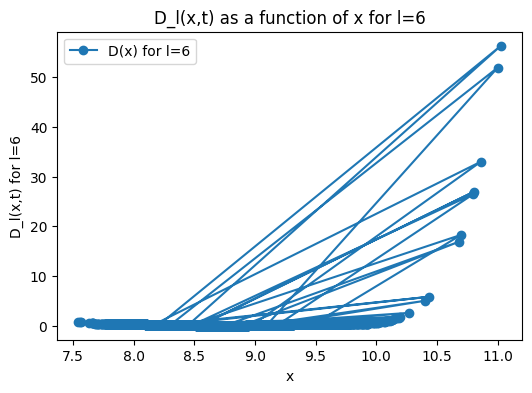

In [10]:
# Plotting D as a function of x for each l value separately
for l_value in l_values:
    plt.figure(figsize=(6, 4))
    plt.plot(data[:-1], all_D_values[l_value], 'o-', label=f'D(x) for l={l_value}')  # Changed to data[:-1]
    plt.xlabel('x')
    plt.ylabel(f'D_l(x,t) for l={l_value}')
    plt.title(f'D_l(x,t) as a function of x for l={l_value}')
    plt.legend()
    plt.show()


#### Another show of shapes side by side

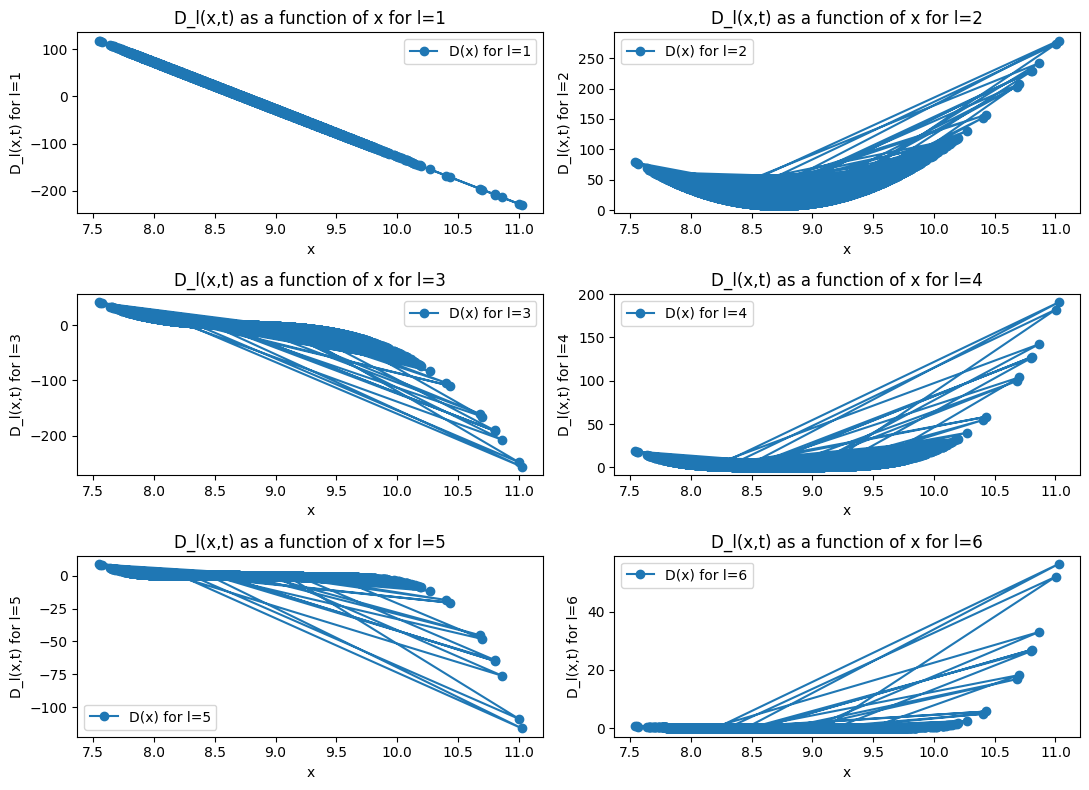

In [13]:
# Plotting D as a function of x for each l value separately
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 8))  # Creating subplots

for i, l_value in enumerate(l_values):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.plot(data[:-1], all_D_values[l_value], 'o-', label=f'D(x) for l={l_value}')  # Changed to data[:-1
    ax.set_xlabel('x')
    ax.set_ylabel(f'D_l(x,t) for l={l_value}')
    ax.set_title(f'D_l(x,t) as a function of x for l={l_value}')
    ax.legend()

plt.tight_layout()
plt.show()

## Mary